# INStarcraft 2 Project: Player Prediction Challenge

The goal of this project is to predict a Starcraft player based on a set of behavioral traces. We use the TRAIN.csv and TEST.csv as raw data for this project. In these csv files, each line denotes the actions made by one player in a single game. Now we will talk about how we handled the raw data in order to train a machine learning model.

First, we import all the necessary libraries. In this challenge, we use a random forest model and the F1 score to evaluate the model.

In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import seaborn as sn
from matplotlib.pyplot import figure


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Read the data
The first step is to read and clean the raw data: the "train.csv" file. Because each line of this file contains the actions of a player in a single game, its length is very different from each other. Here, we want to use pandas library to easily manipulate the data, and since a pandas dataframe has a fixed number of columns, i.e. the length of each line, we need to find a way to fix the length of each line of the raw data file. 
We have chose to find the longest length of a line, then make it as the number of columns of the dataframe, then we fit the raw data into this dataframe.

In [4]:
train_file = './data/train.csv'

largest_nb_column_count = 0

with open(train_file, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(',')) + 1

        # Set the new most column count
        largest_column_count = column_count if largest_nb_column_count < column_count else largest_nb_column_count

column_names = [i for i in range(0, largest_nb_column_count)]
data_df = pd.read_csv(train_file, header=None, names=column_names)

## Approach
Our approach for this project is from the list of actions of each player, we will try to find the features that characterize each player's habit when playing StarCraft 2. 

In [3]:
# Action list to number definition
HOTKEYS = {}
for i in range(10):
    for j in range(3):
        HOTKEYS['hotkey'+str(i)+str(j)] = i*10

SPECIES = {'Protoss': 0, 'Terran': 1, 'Zerg': 2}

The code below transforms the data we have from the DataFrame into different features, and encode some values.
*The features are described in the presentation.*

In [14]:
list_of_dicts = []
first_seconds = 60 # Number of seconds at the beginning of the match to be accounted as "Early game"
for index, row in data_df.iterrows():
    
    # Disregard game that last less than 5 seconds (no timestamps...)
    # This step removes not only outliers - but also allows us to not deal with null rows.
    if row.str.startswith('t').sum == 0:
        continue
    # Disregard games that are too short/long
    game_time = row.str.startswith('t').sum() * 5 // 60 + 1
    if game_time < 3 or game_time > 40:
        continue

    # Creates a dictionary of features for each player
    buffer_dict = {'player_id': row[0], 'species': SPECIES[str(row[1])]}


    # Player's first actions
    first_actions = []
    first_hotkeys = []
    first_hk_position = 0
    first_hk_actions = {"0": 0, "1": 0, "2": 0} # created, updated, used
    #buffer_dict['early_hk0_used'] = -1

    for i in range(2, len(row)):
        if pd.isnull(row[i]):
            break
        # Get the most used hotkey and number of clicks of other actions in the first "first_seconds" seconds
        if str(row[i]).startswith('t'):
            if int(str(row[i])[1:]) == first_seconds:
                if len(first_hotkeys) == 0:
                    buffer_dict['most_freq_early_hk'] = -1
                    buffer_dict['second_freq_early_hk'] = -1
                    buffer_dict['third_freq_early_hk'] = -1
                    buffer_dict['first_hk'] = -1
                    #buffer_dict['early_hk'] = -1
                else: 
                    hk_set = set(first_hotkeys)
                    sorted_set = sorted(hk_set, key=first_hotkeys.count, reverse=True)
                    #buffer_dict['most_freq_early_hk'] = max(set(first_hotkeys), key=first_hotkeys.count)
                    buffer_dict['most_freq_early_hk'] = sorted_set[0]
                    try:
                        buffer_dict['second_freq_early_hk'] = sorted_set[1]
                    except:
                        buffer_dict['second_freq_early_hk'] = -1
                    try:
                        buffer_dict['third_freq_early_hk'] = sorted_set[2]
                    except:
                        buffer_dict['third_freq_early_hk'] = -1
                    buffer_dict['first_hk'] = first_hotkeys[0]
                    #buffer_dict['early_hk'] = len(first_hotkeys)
                buffer_dict['early_s'] = first_actions.count('s')
                buffer_dict['early_base'] = first_actions.count('Base')
                #buffer_dict['early_sm'] = first_actions.count('SingleMineral')
                buffer_dict['early_hk_created'] = first_hk_actions["0"]
                buffer_dict['early_hk_updated'] = first_hk_actions["1"]
                buffer_dict['early_hk_used'] = first_hk_actions["2"]
                break
        elif str(row[i]).startswith('hotkey'):
            if len(first_hotkeys) == 0:
                buffer_dict['first_hk_pos'] = first_hk_position
            # if str(row[i])[-1] == "2" and buffer_dict['early_hk0_used'] == -1:
            #     buffer_dict['early_hk0_used'] = len(first_hotkeys)
            first_hotkeys.append(HOTKEYS[str(row[i])])
            first_hk_actions[str(row[i])[-1]] += 1


        else:
            first_actions.append(str(row[i]))
            first_hk_position += 1

    # Will be removed later on, only used for drawing histogram of game time
    buffer_dict['game_time'] = row.str.startswith('t').sum() * 5 // 60 + 1

    # Count of button presses per minute for the first 30 minutes
    # buffer_dict['s_1'] corresponds to the number of "s" presses from 0:00 to 1:00
    buffer_dict['s'] = len(row[row == 's']) / game_time
    buffer_dict['base'] = len(row[row == 'Base']) / game_time
    buffer_dict['sm'] = len(row[row == 'SingleMineral']) / game_time

    keystrokes = row.count() - 2 - row.str.startswith('t').sum()


    # APM
    #print("*** INDEX: " + str(index) + " ***")
    #print(buffer_dict)
    # Count the number of hotkeys
    for i in range(10):
        buffer_dict['hk'+str(i)] = 0
        for j in range(3):
            mask = row == 'hotkey'+str(i)+str(j)
            buffer_dict['hk'+str(i)] += len(row[mask])
        buffer_dict['hk'+str(i)] /= game_time
    buffer_dict['apm'] = keystrokes / game_time

    # Get the player's maximum number of actions done in every 60 seconds
    # Delete all nan values
    buffer_row = row.dropna()
    # Print the index of all timestamps
    indexes_of_timestamps = list(buffer_row[buffer_row.str.startswith('t')].index)
    max_apm = 0
    for i in range(len(indexes_of_timestamps)-12):
        max_apm = max(max_apm, indexes_of_timestamps[i+12]-indexes_of_timestamps[i]-11)
    buffer_dict['max_apm'] = max_apm


    list_of_dicts.append(buffer_dict)

Upon inspecting the game time (even before we deleted the games that are too short/long), we got quite a decent looking Gaussian distribution.

    Game time (mins)  count
36                 3      6
37                 4      1
30                 5     17
26                 6     29
23                 7     38
18                 8     62
16                 9     72
17                10     71
9                 11    139
10                12    126
5                 13    162
6                 14    153
3                 15    197
2                 16    205
0                 17    213
1                 18    207
4                 19    179
7                 20    146
8                 21    141
11                22    114
12                23     97
13                24     94
14                25     80
19                26     57
15                27     76
21                28     42
22                29     39
20                30     43
25                31     31
24                32     32
28                33     23
27                34     23
34                35      9
29                36     20
31                37

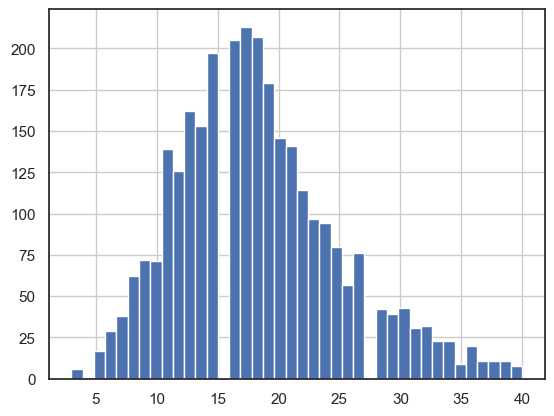

In [15]:
# Create a dataframe from the list of dictionaries
df = pd.DataFrame.from_records(list_of_dicts)
df['game_time'].hist(bins=40)
print(df.head())
preview_game_time_df = df['game_time'].value_counts().reset_index().rename(columns= {'game_time': 'Game time (mins)', 0: 'Count'})
preview_game_time_df = preview_game_time_df.sort_values(by=['Game time (mins)'])
print(preview_game_time_df)

In [ ]:
# Features dropped
df = df.drop(['game_time'], axis=1)

# Check for possible null values
nb_nan = df.isnull().sum()
print(nb_nan)

## Machine learning model
The next step is to prepare the input data for the machine learning model. As mentioned above, we used the Random Forest Classifier with a split of 80-20 for validation. The seed was fixed at first, and removed afterwards for us to witness how much it changes every iteration.

In [25]:
# Seperate data into features and target
X = df.drop(['player_id'], axis=1)
y = df['player_id']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [26]:
# Create a random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Calcul de l'erreur de prédiction
accuracy = model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro')
print('F1:', f1) # Best: 0.86414
print('Accuracy:', accuracy) # Best: 0.94472

F1: 0.8610301500132008
Accuracy: 0.9246231155778895


The F1 score was very consistent around **80-90%**, and the accuracy was relatively high at around 90%. The model was very good.

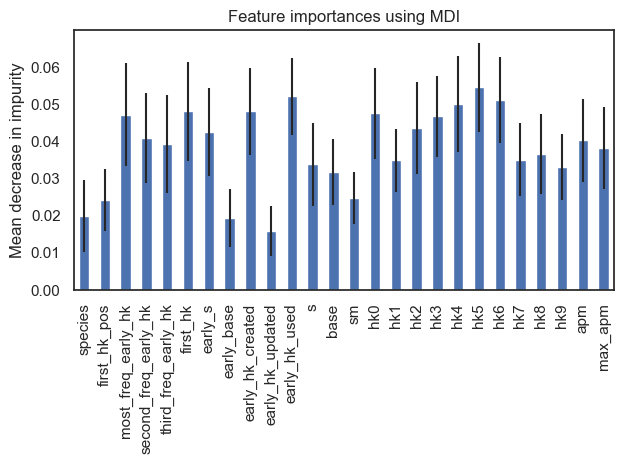

In [27]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


<Axes: >

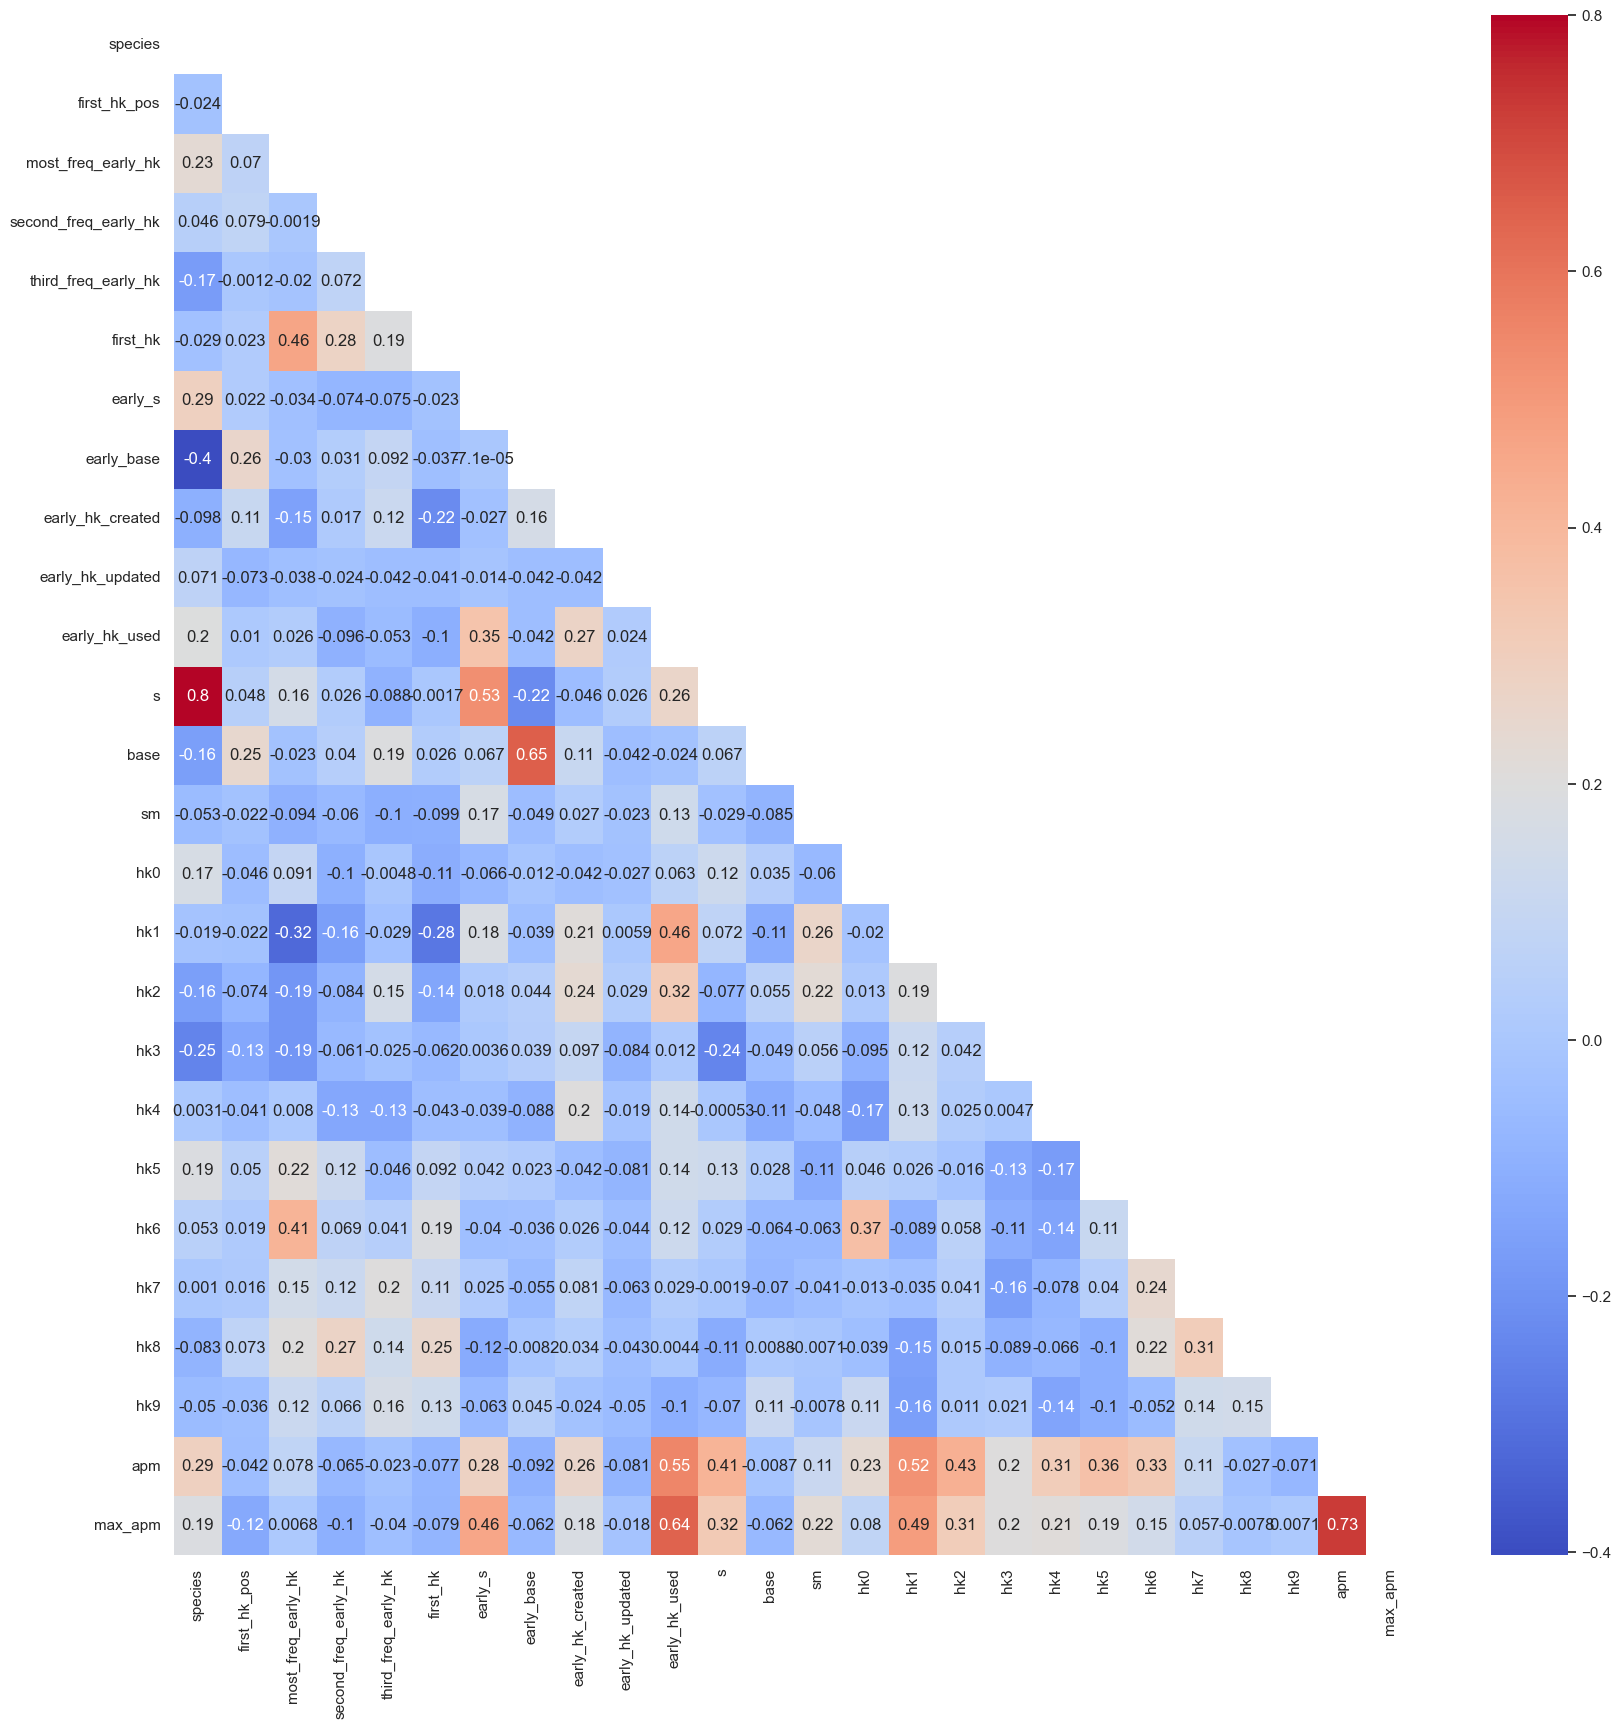

In [28]:
# Correlation heatmap
corrMatrix = df.drop(['player_id'], axis=1).corr()
figure(figsize=(20, 20))
sn.set_theme(style="white")
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))
sn.heatmap(corrMatrix, annot=True, mask=mask, cmap='coolwarm')

## Prediction part
The final step was to use the model to predict using the `TEST.CSV` file. We do the same steps as before for the data in the test file.
Starting off with reading the data:

In [29]:
### TEST ###
test_file = './data/TEST.CSV'

largest_column_count = 0

with open(train_file, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines:
        # Count the column count for the current line
        column_count = len(l.split(',')) + 1

        # Set the new most column count
        largest_column_count = column_count if largest_column_count < column_count else largest_column_count

column_names = [i for i in range(0, largest_column_count)]
test_df = pd.read_csv(test_file, header=None, names=column_names)

Afterward, a DataFrame of features is created. The code is virtually the same for this part, with the exception of not removing any games for obvious reasons.

In [30]:
### PREDICTION
test_dicts = []
for index, row in test_df.iterrows():
    # Creates a dictionary of features for each player
    # Player's species (Protoss, Terran, Zerg) - 0, 1, 2
    buffer_dict = {'species': SPECIES[str(row[0])]}

    # Player's first actions
    first_actions = []
    first_hotkeys = []
    first_hk_position = 0
    first_hk_actions = {"0": 0, "1": 0, "2": 0} # created, updated, used

    for i in range(1, len(row)):
        if pd.isnull(row[i]):
            break
        # Get the most used hotkey and number of clicks of other actions in the first "first_seconds" seconds
        if str(row[i]).startswith('t'):
            if int(str(row[i])[1:]) == first_seconds:
                if len(first_hotkeys) == 0:
                    buffer_dict['most_freq_early_hk'] = -1
                    buffer_dict['second_freq_early_hk'] = -1
                    buffer_dict['third_freq_early_hk'] = -1
                    buffer_dict['first_hk'] = -1
                    #buffer_dict['early_hk'] = -1
                else: 
                    hk_set = set(first_hotkeys)
                    sorted_set = sorted(hk_set, key=first_hotkeys.count, reverse=True)
                    buffer_dict['most_freq_early_hk'] = sorted_set[0]
                    # buffer_dict['most_freq_early_hk'] = max(set(first_hotkeys), key=first_hotkeys.count)
                    try:
                        buffer_dict['second_freq_early_hk'] = sorted_set[1]
                    except:
                        buffer_dict['second_freq_early_hk'] = -1
                    try:
                        buffer_dict['third_freq_early_hk'] = sorted_set[2]
                    except:
                        buffer_dict['third_freq_early_hk'] = -1
                    buffer_dict['first_hk'] = first_hotkeys[0]
                    #buffer_dict['early_hk'] = len(first_hotkeys)
                buffer_dict['early_s'] = first_actions.count('s')
                buffer_dict['early_base'] = first_actions.count('Base')
                #buffer_dict['early_sm'] = first_actions.count('SingleMineral')
                buffer_dict['early_hk_created'] = first_hk_actions["0"]
                buffer_dict['early_hk_updated'] = first_hk_actions["1"]
                buffer_dict['early_hk_used'] = first_hk_actions["2"]
                break

        elif str(row[i]).startswith('hotkey'):
            if len(first_hotkeys) == 0:
                buffer_dict['first_hk_pos'] = first_hk_position
            # if str(row[i])[-1] == "2" and buffer_dict['early_hk0_used'] == -1:
            #     buffer_dict['early_hk0_used'] = len(first_hotkeys)
            first_hotkeys.append(HOTKEYS[str(row[i])])
            first_hk_actions[str(row[i])[-1]] += 1


        else:
            first_actions.append(str(row[i]))
            first_hk_position += 1

    # Player's APM calculation
    apm = 0

    game_time = row.str.startswith('t').sum() * 5 // 60 + 1
    buffer_dict['game_time'] = row.str.startswith('t').sum() * 5 // 60 + 1
    # Count of button presses per minute for the first 30 minutes
    # buffer_dict['s_1'] corresponds to the number of "s" presses from 0:00 to 1:00
    buffer_dict['s'] = len(row[row == 's']) / game_time
    buffer_dict['base'] = len(row[row == 'Base']) / game_time
    buffer_dict['sm'] = len(row[row == 'SingleMineral']) / game_time
    keystrokes = row.count() - 1 - row.str.startswith('t').sum()

    # Count the number of hotkeys
    for i in range(10):
        buffer_dict['hk'+str(i)] = 0
        for j in range(3):
            mask = row == 'hotkey'+str(i)+str(j)
            buffer_dict['hk'+str(i)] += len(row[mask])
        buffer_dict['hk'+str(i)] /= game_time
    
    # APM
    buffer_dict['apm'] = keystrokes / game_time

    # Max APM
    # Delete all nan values
    buffer_row = row.dropna()
    # Print the index of all timestamps
    indexes_of_timestamps = list(buffer_row[buffer_row.str.startswith('t')].index)
    max_apm = 0
    for i in range(len(indexes_of_timestamps)-12):
        max_apm = max(max_apm, indexes_of_timestamps[i+12]-indexes_of_timestamps[i]-11)
    buffer_dict['max_apm'] = max_apm

    test_dicts.append(buffer_dict)

Finally, we make the prediction and write the result into a `.csv` file.

340


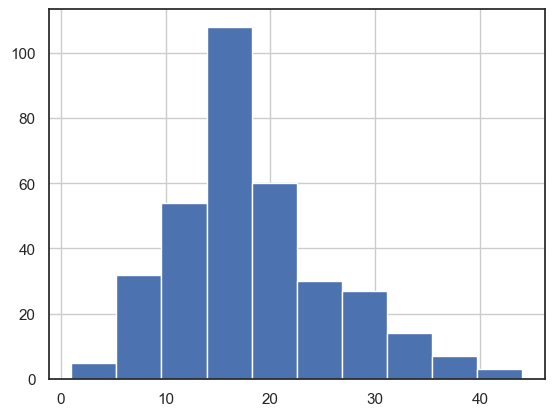

In [31]:
pred_df = pd.DataFrame.from_records(test_dicts).fillna(-1)
pred_df['game_time'].hist(bins=10)
pred_df = pred_df.drop(['game_time'], axis=1)
prediction = model.predict(pred_df)
print(len(prediction))
submission_dict = {'RowId': [], 'prediction': []}
for i in range(len(prediction)):
    submission_dict['RowId'].append(i+1)
    submission_dict['prediction'].append(prediction[i])
submission_df = pd.DataFrame(submission_dict)
submission_df.to_csv('submission.csv', index=False)
# with open('submission.csv', 'w', encoding="utf-8") as csvfile:
#     csvwriter = csv.writer(csvfile)
#     csvwriter.writerow(fields)
#     csvwriter.writerows(rows)

We also tried using an MLP classifier, but the performance was far worse than our random forest.

In [32]:
# Create a MLP classifier (a try...)
other_model = MLPClassifier(random_state=1)
other_model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = other_model.predict(X_test)

# Calcul de l'erreur de prédiction
accuracy = other_model.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='macro')
print('F1:', f1)
print('Accuracy:', accuracy)

F1: 0.7943105867701162
Accuracy: 0.8760469011725294
